In [2]:
#%% Library
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
homedir = '/Users/hhchoi1022/Gitrepo/7DT/SPHEREx'
os.chdir(homedir)
from spherex_helper import tophat_trans
from scipy.ndimage import gaussian_filter
from scipy.integrate import trapezoid

#%% Constant
h_mks = 6.626e-34
h_cgs = 6.626e-27
c_cm = 3e10
c_m = 3e8
rad2arcsec = (180/np.pi*3600)
arcsec2rad = 1/rad2arcsec
k = 1.38e-23 
c_ums = 3e14

##### Filter info : filter_set
##### Total response info : response
##### Parameters
"""
    fwhm    <<< fwhm for aperture
    texp    <<< exposure time
    lambda_7ds    <<< filterset construction
    wave_lvf    <<< [um] lamb_start, lamb_end
    eff_mirrors    <<< efficiency of the mirror
    eff_optics    <<< efficiency of the optics
    eff_filter    <<< efficiency of the filter
    and many configuration for the telescope & detector
"""

'\n    fwhm    <<< fwhm for aperture\n    texp    <<< exposure time\n    lambda_7ds    <<< filterset construction\n    wave_lvf    <<< [um] lamb_start, lamb_end\n    eff_mirrors    <<< efficiency of the mirror\n    eff_optics    <<< efficiency of the optics\n    eff_filter    <<< efficiency of the filter\n    and many configuration for the telescope & detector\n'

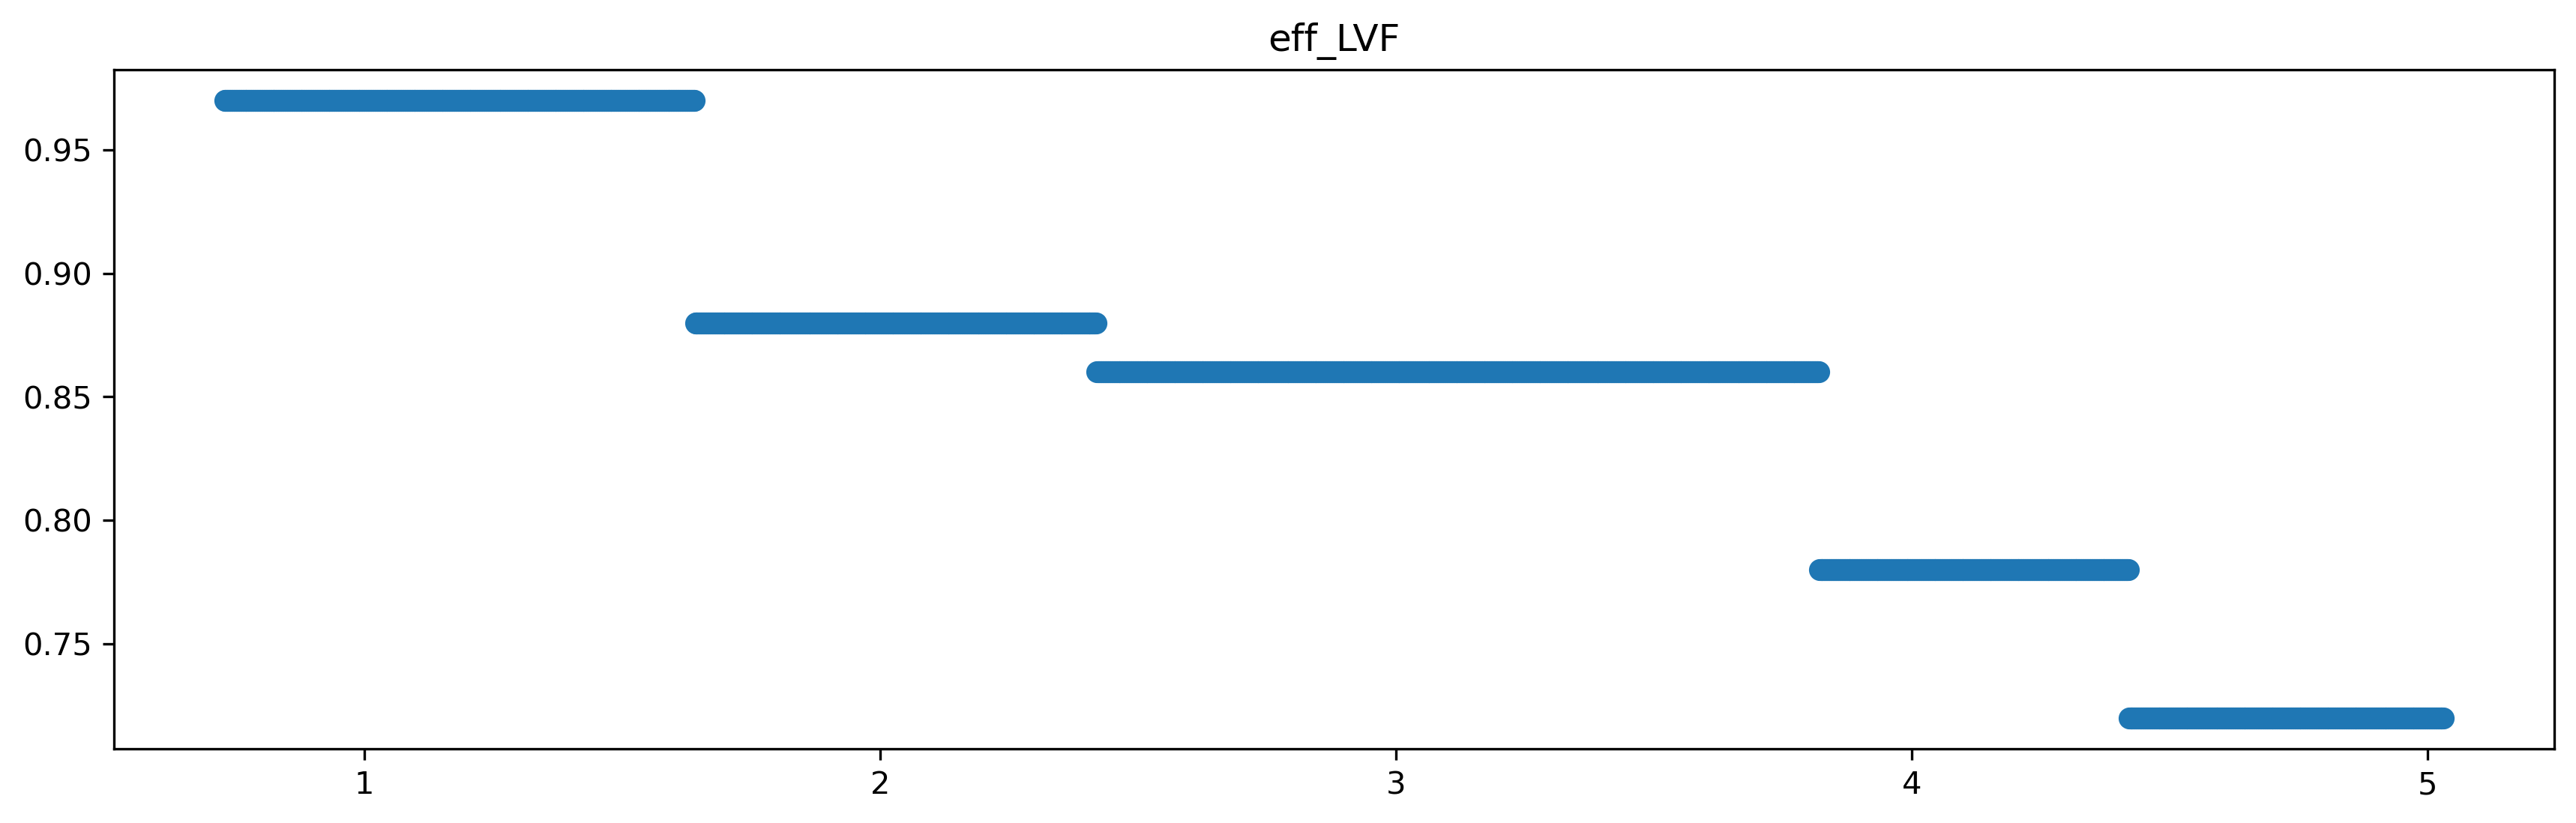

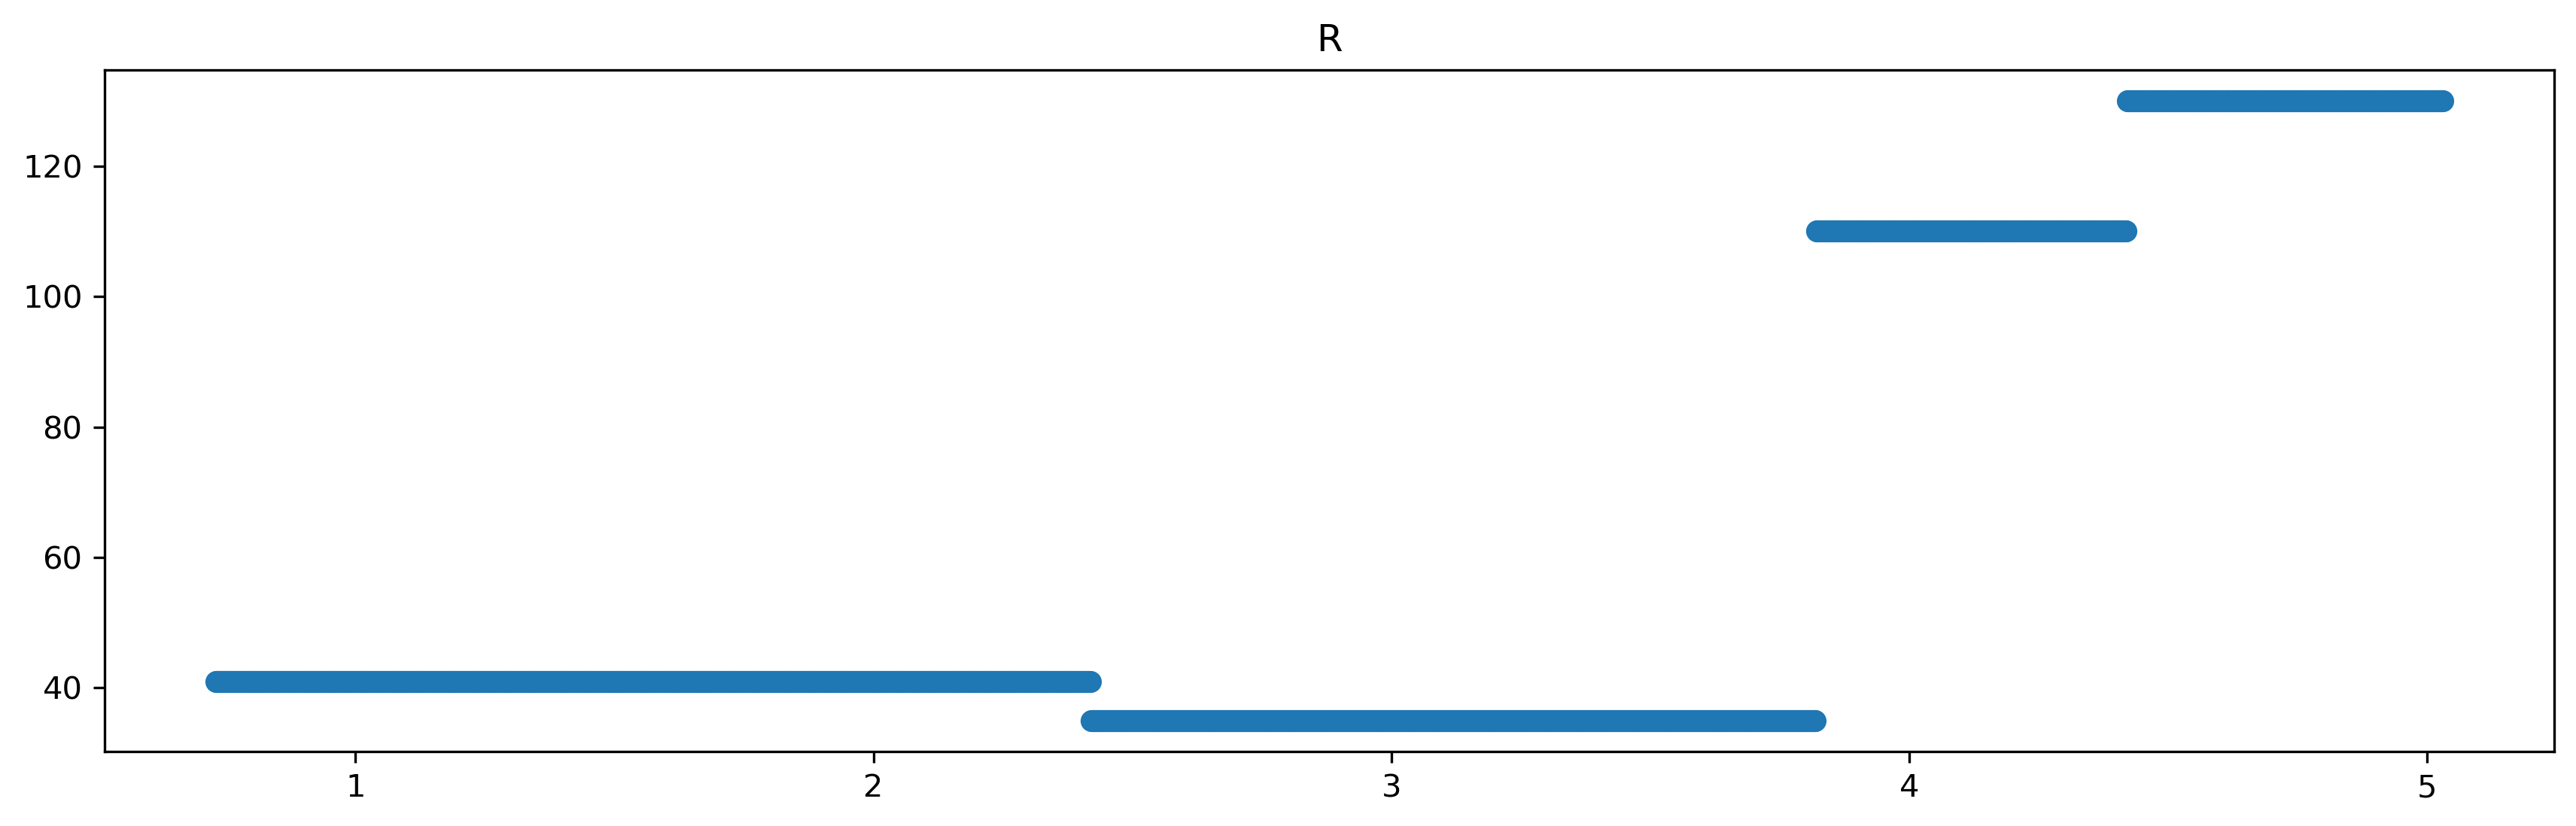

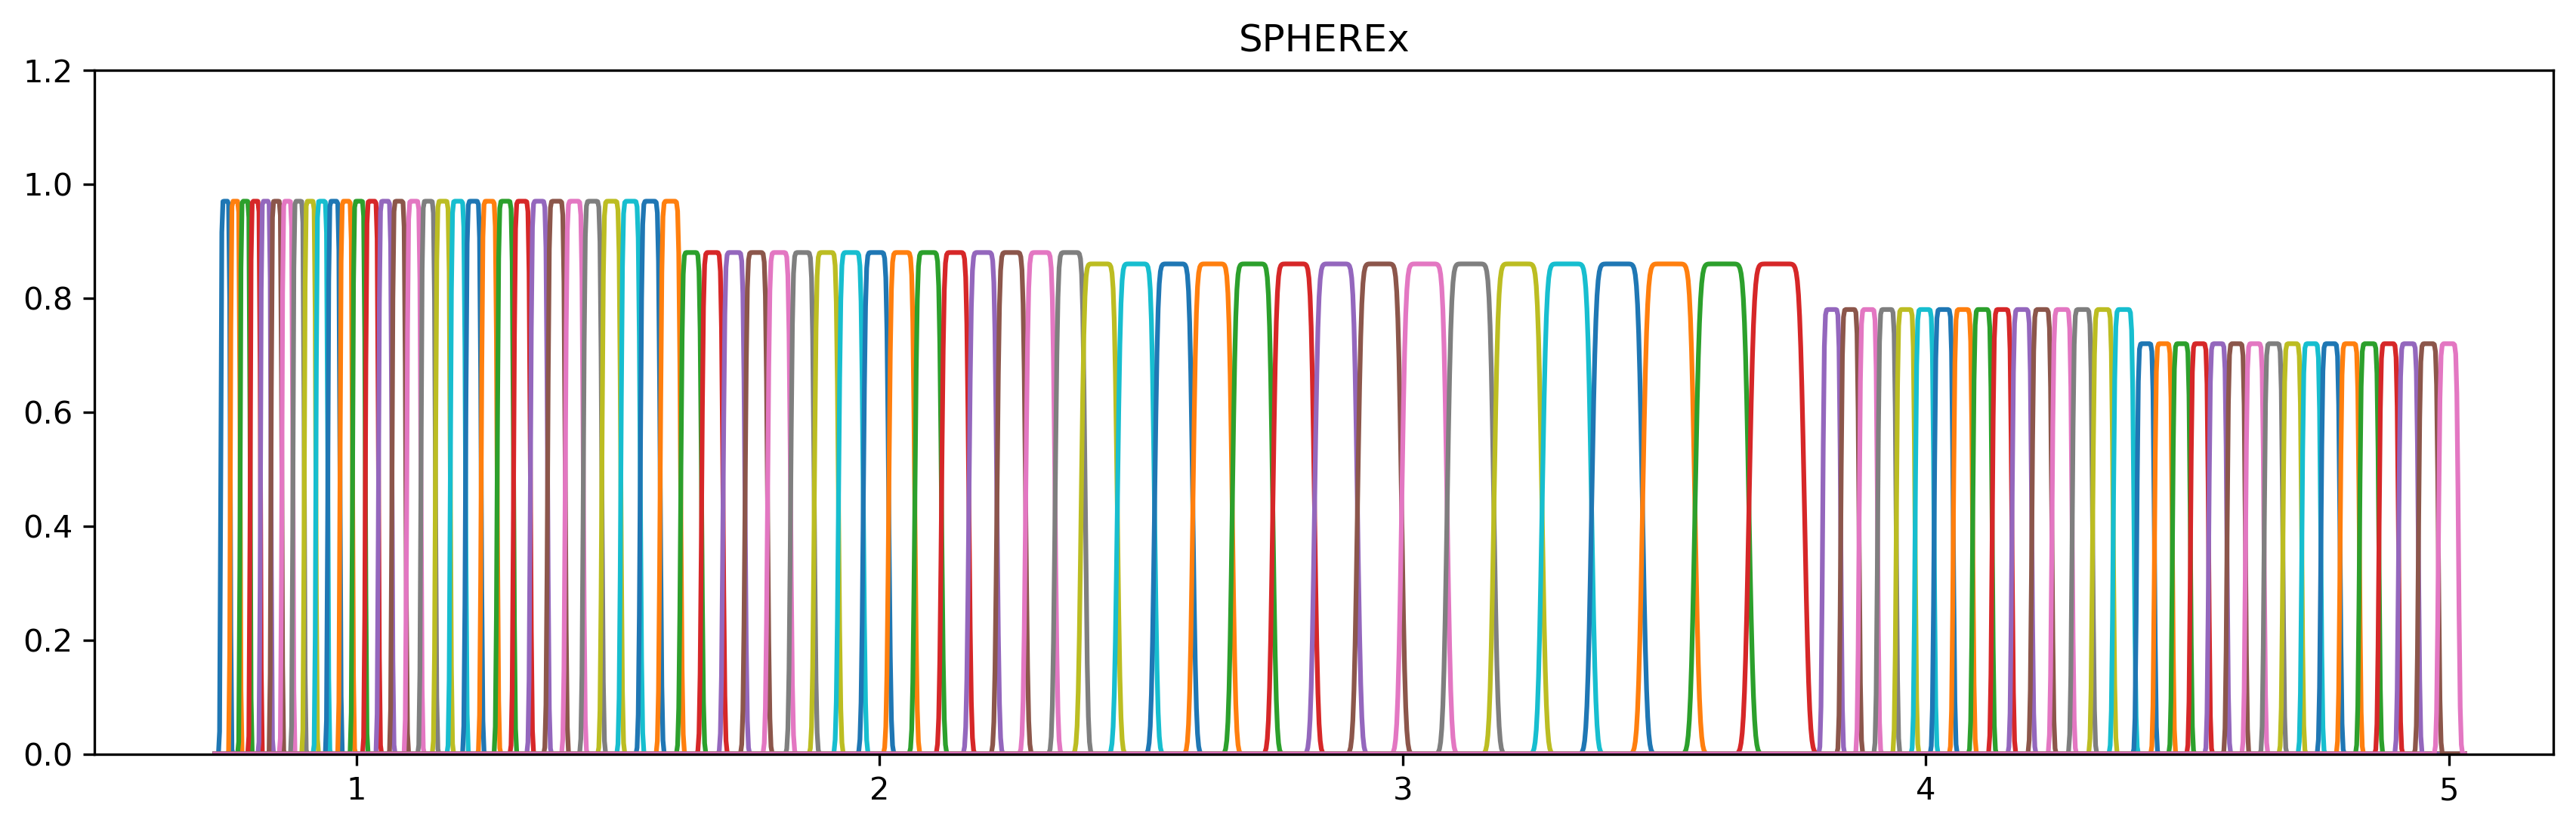

In [64]:
#%% Filter
SPHEREx_lambda_min = np.array([0.75, 1.11, 1.64, 2.42, 3.82, 4.42])  # [um] starting wavelength     #########################CHANGABLE#############################
SPHEREx_lambda_max = np.array([1.11, 1.64, 2.42, 3.82, 4.42, 5.01])  # [um] ending wavelength   #########################CHANGABLE#############################
SPHEREx_R = np.array([41, 41, 41, 35, 110, 130])                     # Resolving power  #########################CHANGABLE#############################
SPHEREx_eff_LVF = np.array([0.97, 0.97, 0.88, 0.86, 0.78, 0.72])     # LVF efficiency   #########################CHANGABLE#############################
wl_lvf = np.linspace(0.73, 5.03, 2000)

all_R = np.zeros(2000)
all_LVFlist = np.zeros(2000)
for min_, max_, value_R, value_lvf in zip(SPHEREx_lambda_min, SPHEREx_lambda_max, SPHEREx_R, SPHEREx_eff_LVF):
    for i, wl in enumerate(wl_lvf):
        if (wl >= min_) & (wl <= max_):
            all_R[i] = value_R
            all_LVFlist[i] = value_lvf
all_LVFlist[:23] = 0.97
all_LVFlist[-23:] = 0.72
all_R[:23] = 41
all_R[-23:] = 130

lcenlist = []
wave_lvf = []
Rlist = []
e_LVFlist = []
for lmin, lmax, R, eff in zip(SPHEREx_lambda_min,SPHEREx_lambda_max,SPHEREx_R, SPHEREx_eff_LVF):
    Nchan = 1
    lcen = lmin
    while lcen<lmax-0.01:
        fwhm = lcen/R
        lvf = tophat_trans(wl_lvf, center = lcen, fwhm = fwhm) * eff
        lcenlist.append(lcen)
        Rlist.append(R)
        e_LVFlist.append(eff)
        wave_lvf.append(lvf)
        lcen = lmin * ((2*R + 1)/(2*R - 1))**Nchan
        Nchan += 1
lcenlist = np.array(lcenlist)
filter_set = {'cwl': lcenlist,
              'wave': wl_lvf}

# Graph
plt.figure(figsize=(14, 4), dpi = 300)
plt.title('eff_LVF')
plt.scatter(wl_lvf, all_LVFlist)
plt.show()

plt.figure(figsize=(14, 4), dpi = 300)
plt.title('R')
plt.scatter(wl_lvf, all_R)
plt.show()

plt.figure(figsize=(14, 4), dpi = 300)
plt.title('SPHEREx')
for i, lvf in enumerate(wave_lvf):
    filter_set.update({f'{i}': lvf})
    plt.plot(wl_lvf, lvf)

plt.xlim(0.5, 5.2)
plt.ylim(0.00, 1.20)
plt.show()



In [65]:
#%% Telescope 
# Mirror
D = 20  #########################CHANGABLE#############################
Fnumber = 3 #########################CHANGABLE#############################
EFL = D*Fnumber*1e1    # [mm]   #########################CHANGABLE#############################
D_eff = D
WFE = 0.25  # [um] wave front error
rms_pointing = 1.0  # [arcsec] pointing accuracy
# Detector
dQ_CDS = 12.5
Tsamp = 1.5
Tint = 153.33
I_dark = 0.01        # [e/s], dark current  #########################CHANGABLE#############################
pixel_size = 18.0    # [um], "pitch"  #########################CHANGABLE#############################
theta_pixel = 6.19  # [arcsec], pixel scale  #########################CHANGABLE#############################
nxpix, nypix = 2048, 2048  # [pixels], detector format, approx. 9k x 6k  #########################CHANGABLE#############################
theta_diffraction = 1.22 * (lcenlist*1e-4) / D * rad2arcsec   # diffraction-limited PSF size = 1.22 (lambda/D)
pixel_sr = (theta_pixel*arcsec2rad)**2  # Area of a pixel in steradian
AOmega = np.pi * (D/2/100)**2 * pixel_sr   # (Area) x (solid angle) per pixel [m^2 sr]

Text(0, 0.5, 'FWHM [arcsec]')

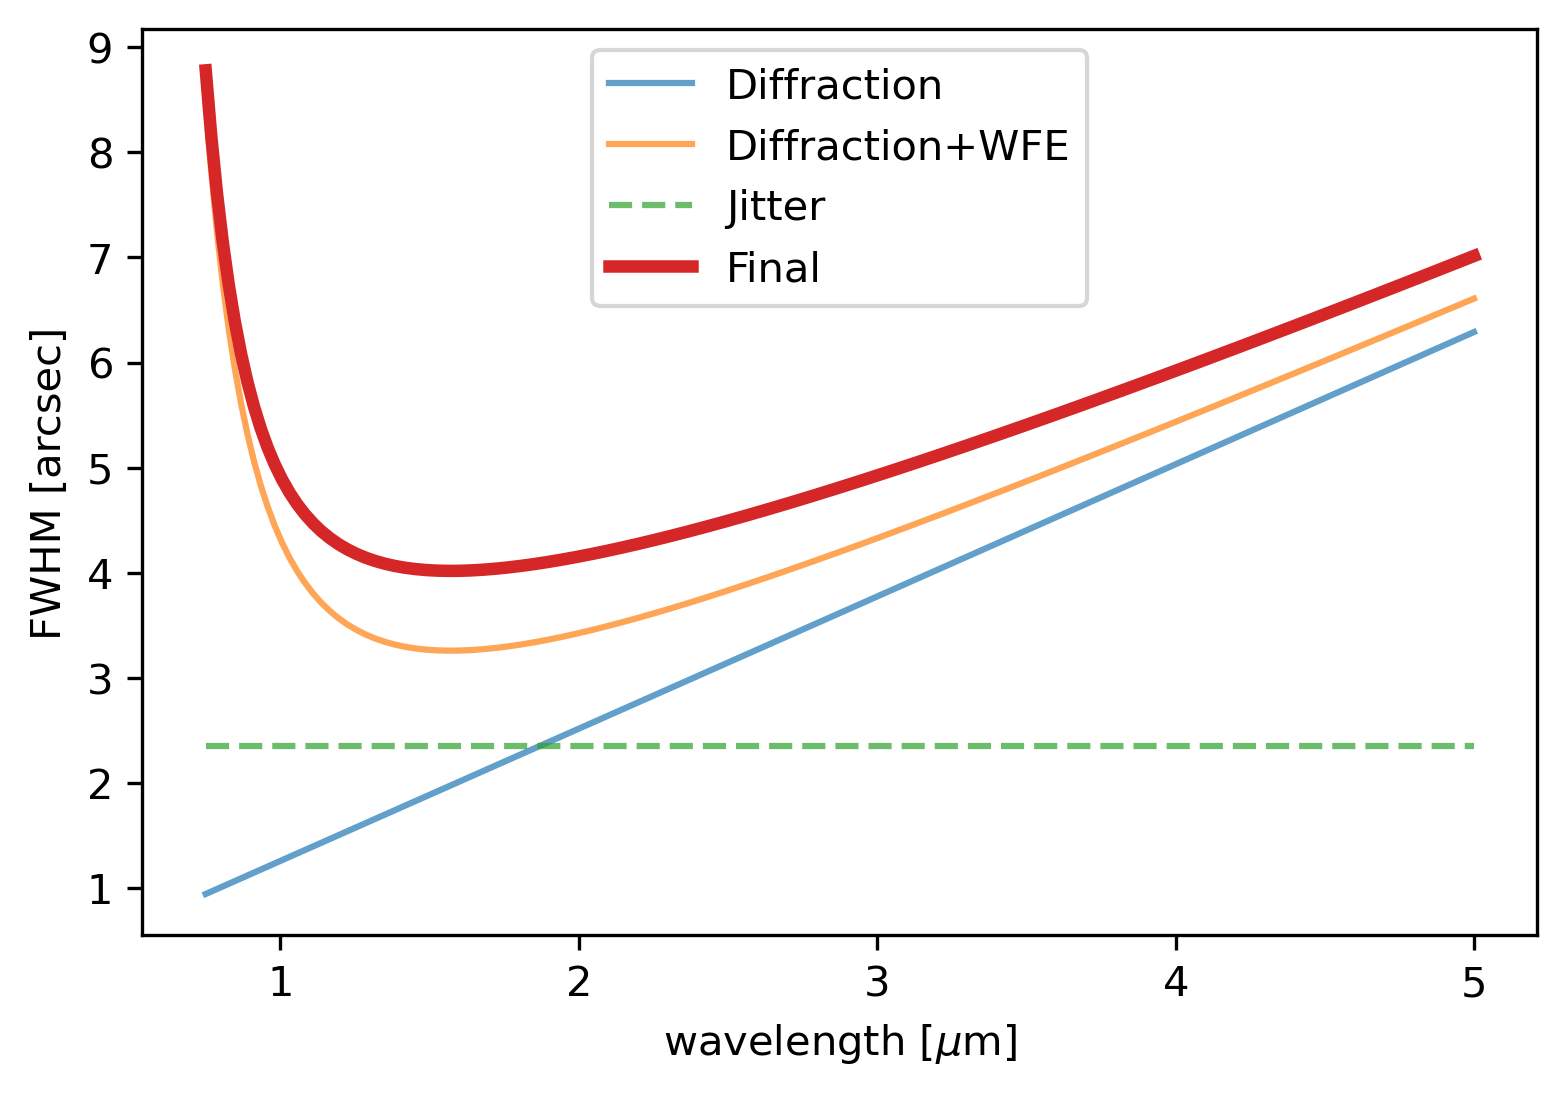

In [189]:
#%% FWHM 
def calc_fwhm(lcen):
    # Diffraction-limited PSF width
    fwhm_diffraction = 1.22*lcen/(D_eff*1e4) * rad2arcsec

    # PSF width due to the wave front error
    # Note that this equation is over-approximation at shorther wavelength!
    fwhm_wfe = fwhm_diffraction * np.sqrt(np.exp((2*np.pi*WFE/lcen)**2))

    # Different approximation can be used!
    # fwhm_wfe = fwhm_diffraction * sqrt(1 + (2*pi*WFE/wl)**2)
    # fwhm_wfe = fwhm_diffraction *     (1 + (2*pi*WFE/wl)**2)

    # PSF due to spacecraft pointing stability
    fwhm_jitter = rms_pointing * 2.35 * np.ones_like(lcen)

    # Final PSF width = quadrature sum of the two
    fwhm_final = np.sqrt(fwhm_wfe**2 + fwhm_jitter**2)
    return fwhm_final
fwhm_final = calc_fwhm(lcenlist)
plt.figure(dpi = 300)
plt.plot(lcenlist, fwhm_diffraction, label='Diffraction', alpha=0.7)
plt.plot(lcenlist, fwhm_wfe, label='Diffraction+WFE', alpha=0.7)
plt.plot(lcenlist, fwhm_jitter, label='Jitter', alpha=0.7, linestyle='--')
plt.plot(lcenlist, fwhm_final, label='Final', linewidth=3)
plt.legend()
plt.xlabel('wavelength [$\mu$m]')
plt.ylabel('FWHM [arcsec]')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


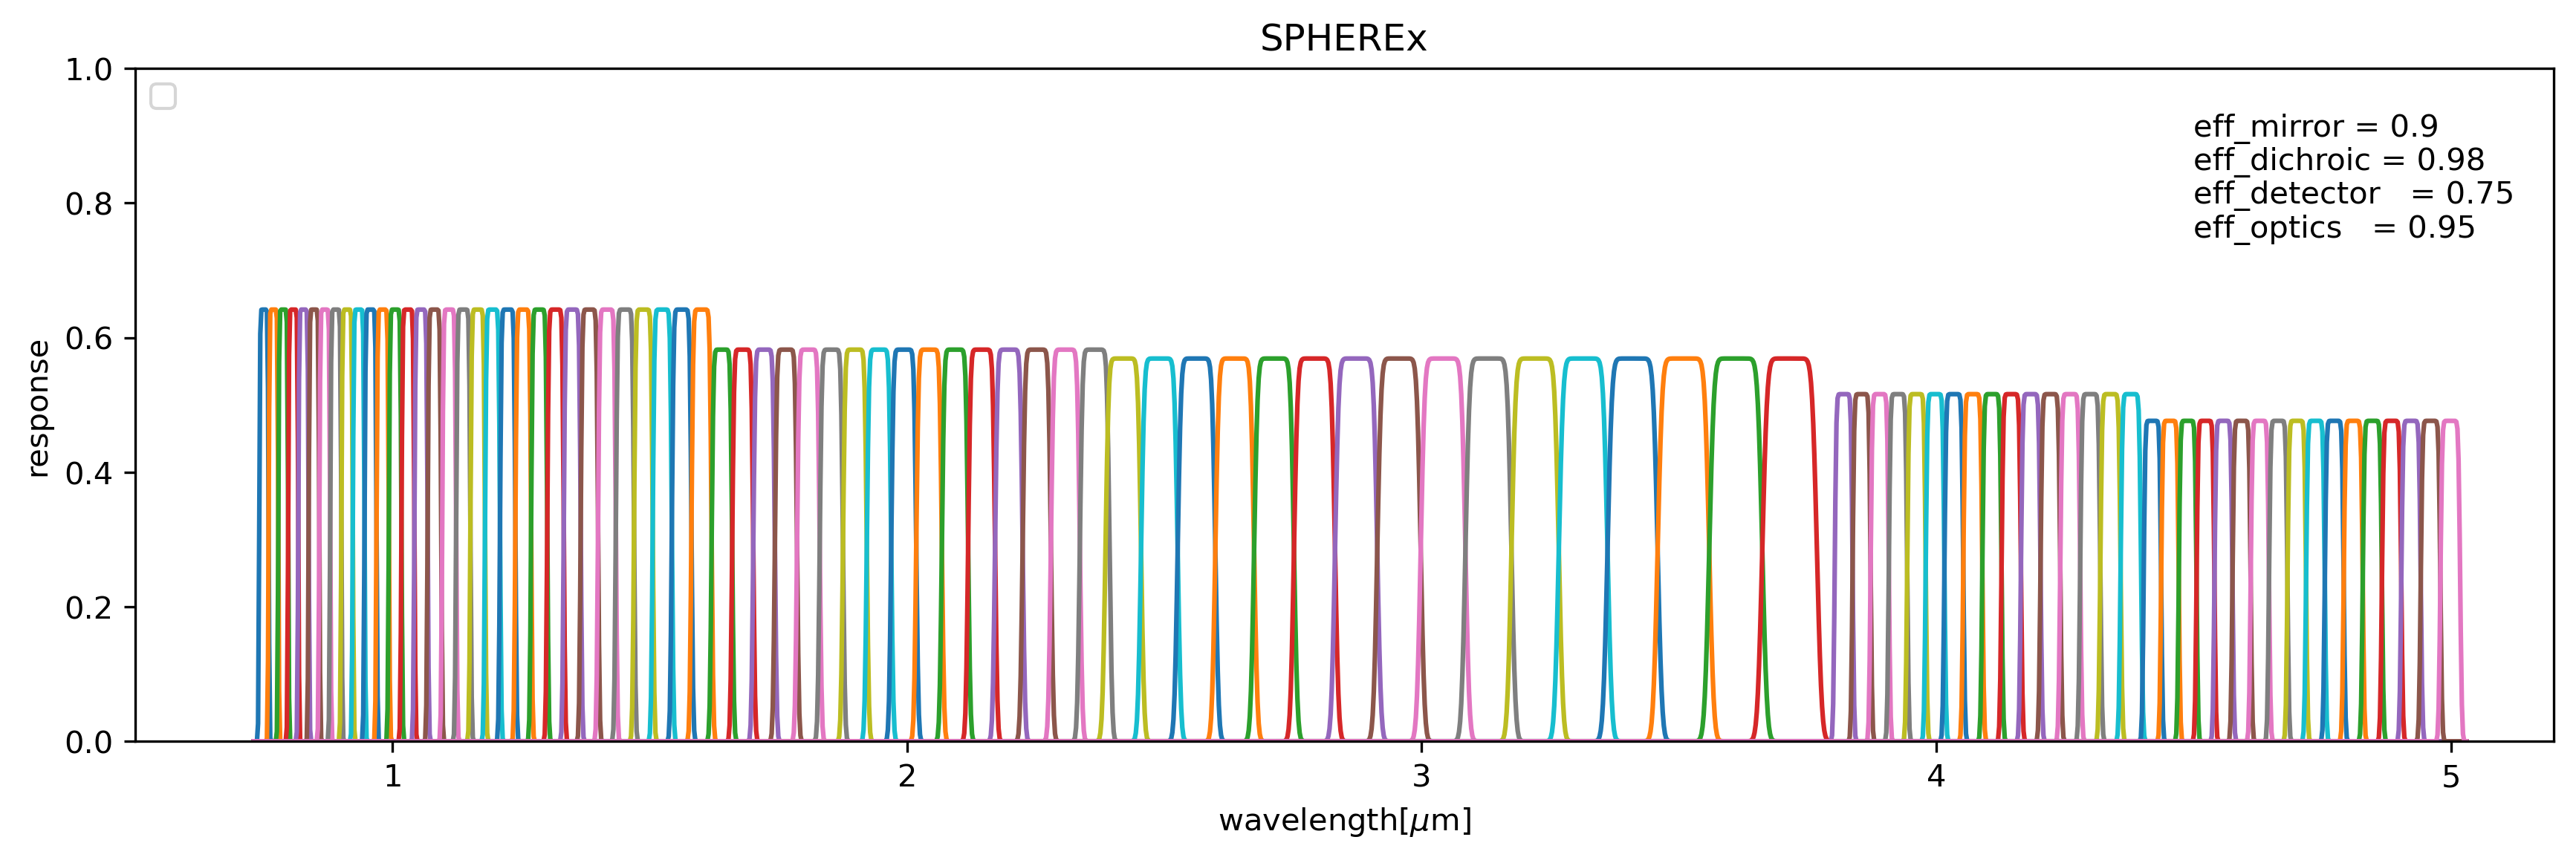

In [67]:
#%% Total response curve (Telescope + Atmosphere + Filter )
eff_mirrors = round(0.965 **3,2) #########################CHANGABLE#############################
eff_dichroic = 0.98     # splitter  #########################CHANGABLE#############################
eff_detector = 0.75     # Detector Quantum Efficiency (QE)  #########################CHANGABLE#############################
eff_optics = 0.95   #########################CHANGABLE#############################
eff_opt = eff_mirrors * eff_dichroic
eff_total = eff_opt * eff_detector
T_scope = 80 # [K] Temperature of the telescope
T_FPA = 50 # [K] Temperature of the focal plane array(FPA)

response = {'cwl': lcenlist,
            'wave': wl_lvf,
            'R':Rlist}

for i, lcen in enumerate(response['cwl']):
    real_lvf = eff_total * filter_set[f'{i}']
    response.update({f'{i}': real_lvf})

plt.figure(figsize=(14, 4), dpi = 300)
plt.title('SPHEREx')
for i in range(len(response['cwl'])):
    lvf = response[f'{i}']
    #filter_set.update({f'{i}': lvf})
    plt.plot(response['wave'], lvf)

plt.xlim(0.5, 5.2)
plt.ylim(0.00, 1.0)

plt.text(4.5,0.90, f'eff_mirror = {eff_mirrors}')
plt.text(4.5,0.85,f'eff_dichroic = {eff_dichroic}')
plt.text(4.5,0.80, f'eff_detector   = {eff_detector}')
plt.text(4.5,0.75, f'eff_optics   = {eff_optics}')

plt.xlabel(r'wavelength[$\mu$m]')
plt.ylabel('response')
plt.legend(loc = 2)
plt.show()

### #%% Noise source (Readout noise & Dark noise & Zodiacal shot noise)

In [72]:
#%% Thermal background from telescope & FPA
# Telescope
def thermnoise_tel(wave_um,T_scope):
    hc_kTlambda = h_mks * (c_ums/wave_um) / (k*T_scope)
    nuInu_scope = (2*h_mks/c_m**2) * (c_ums / wave_um)**4 / (np.exp(hc_kTlambda) - 1) / 1e-9
    return nuInu_scope

nuInu_scope = thermnoise_tel(lcenlist, T_scope)

# FPA
def thermnoise_FPA(wave_um,T_FPA):
    hc_kTlambda = h_mks * (c_ums/wave_um) / (k*T_FPA)
    nuInu_FPA   = (2*h_mks/c_m**2) * (c_ums / wave_um)**4 / (np.exp(hc_kTlambda) - 1) / 1e-9
    return nuInu_FPA

nuInu_FPA = thermnoise_FPA(lcenlist, T_FPA)

# Iphoto (Telescope & FPA)
# Count rates [e/s]
I_scope = 1e-9 * nuInu_scope * np.pi*(pixel_size*1e-6)**2/Rlist*e_LVFlist*eff_detector/(h_mks*c_ums/lcenlist)
I_FPA   = 1e-9 * nuInu_FPA   * np.pi*(pixel_size*1e-6)**2          *eff_detector/(h_mks*c_ums/lcenlist)

Text(0, 0.5, '$\\nu I_\\nu$ [nW/m2/sr]')

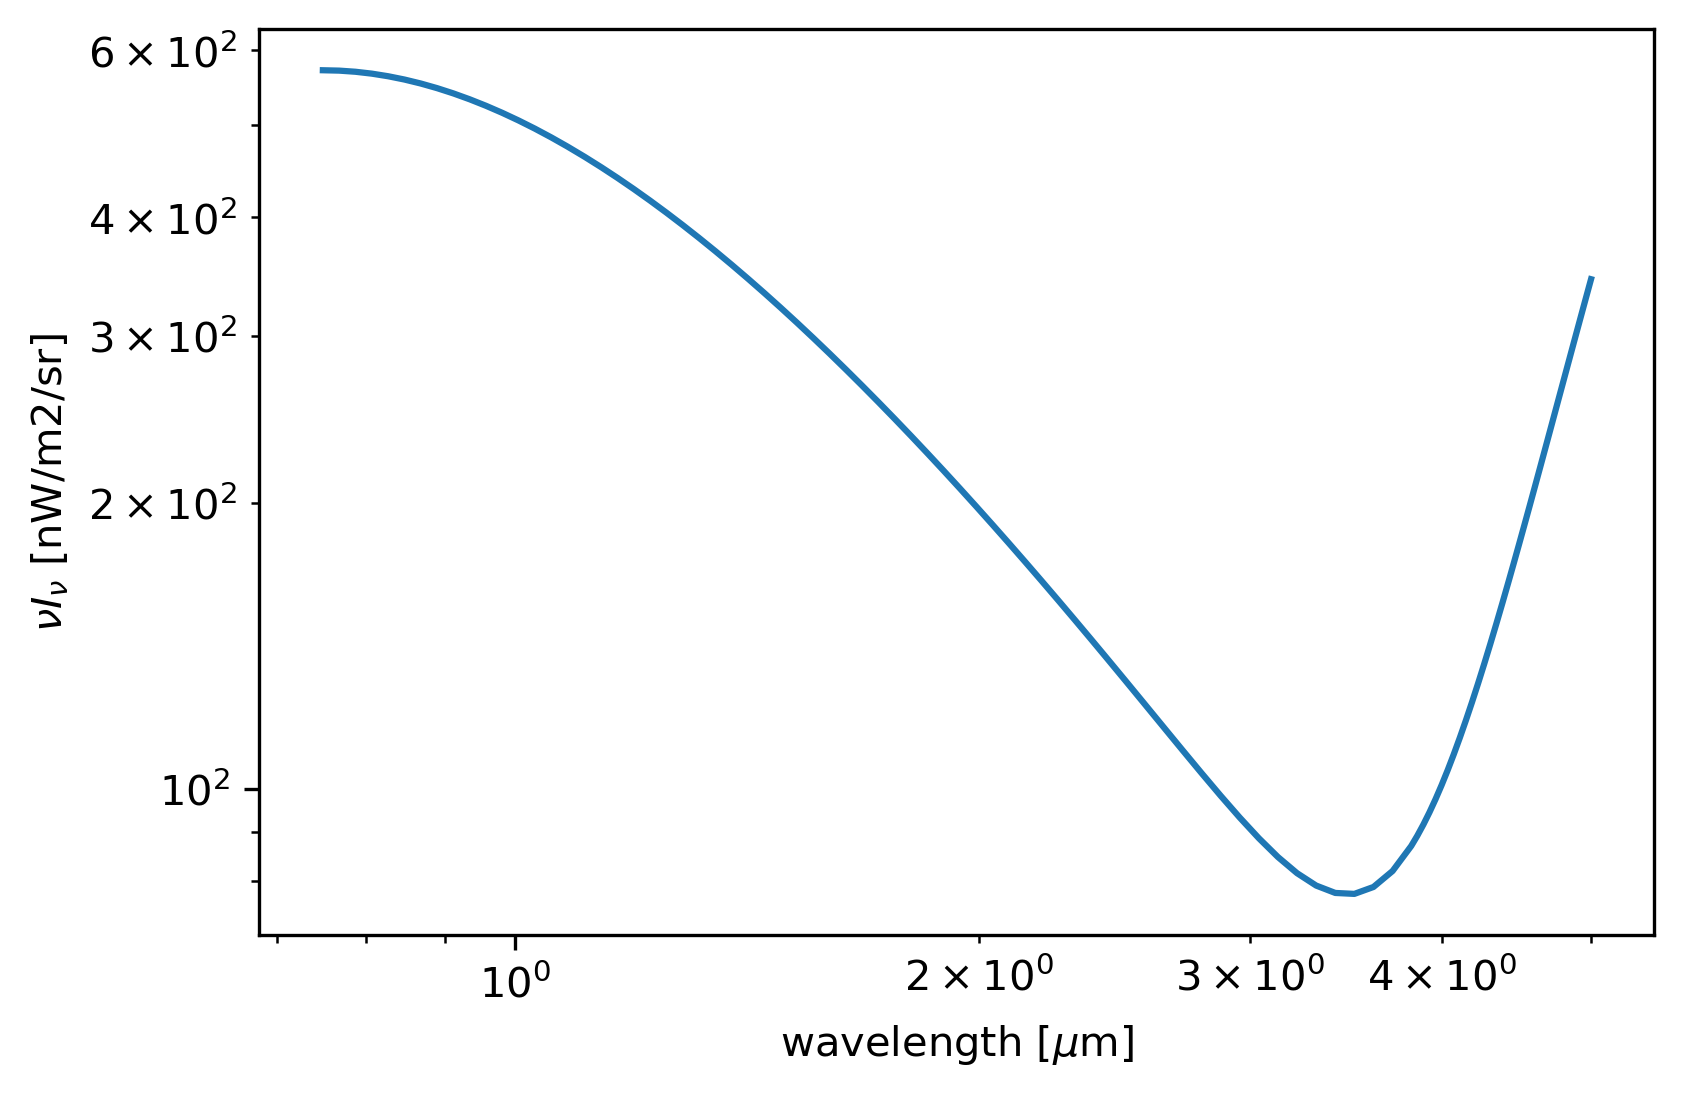

In [76]:
#%% Zodiacal Light
def nuInu_ZL(lambda_um, f_ZL=1.7):
    # very rough approximation for ZL
    # nuInu(sky): fit for zodiacal light [nW/m2/sr]
    # f_ZL = a fudge factor for margin
    A_scat = 3800
    T_scat = 5500
    b_scat = 0.4
    A_therm = 5000
    T_therm = 270
    nuInu = f_ZL * ( A_scat*(lambda_um**b_scat)*((lambda_um)**(-4))/(np.exp(h_mks*c_ums/(k*T_scat *lambda_um))-1)
                    +A_therm*1000000           *((lambda_um)**(-4))/(np.exp(h_mks*c_ums/(k*T_therm*lambda_um))-1) )
    return nuInu
plt.figure(dpi  =300)
wl = np.logspace(np.log10(0.3), np.log10(100), 100)
plt.plot(lcenlist, nuInu_ZL(lcenlist))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('wavelength [$\mu$m]')
plt.ylabel(r'$\nu I_\nu$ [nW/m2/sr]')

In [77]:
Sh_Redun = 2
T_mission = 2

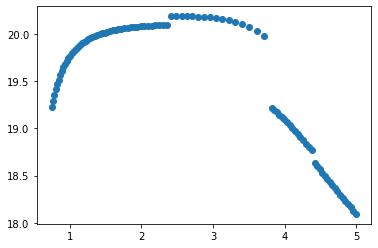

In [123]:
# Zodiacal light [sensitivity]
nuInu = nuInu_ZL(response['cwl']) # [nW/m2/sr]
I_photo = 1e-9 * nuInu*AOmega*eff_total/(np.array(response['R'])*h_mks*c_ums/response['cwl'])  # [e/s]
I_photo = I_photo + I_scope + I_FPA
# Noise in count per obs [e]. 
# f_margin = 1.2 due to background estimation
Q_photo = (I_photo+I_dark)*Tint
dQ_photo = np.sqrt( 1.2*(I_photo+I_dark)*Tint )
# Noise in count rate [e/s]
dQ_RN = dQ_CDS*np.sqrt(6*Tsamp/Tint)   # [e], readout noise   #########################CHANGABLE#############################
dI_photo = np.sqrt(dQ_photo**2 + dQ_RN**2)/Tint     # [e/s]

# Noise in nuInu [nW/M2/sr]
dnuInu_obs = (dI_photo/I_photo)*(nuInu + nuInu_scope + nuInu_FPA)
dnuInu_sh = dnuInu_obs / np.sqrt(Sh_Redun) / np.sqrt(T_mission)
# Signal in nuInu [nW/M2/sr]
nuInu_obs = I_photo * 1e9 * (np.array(response['R'])*h_mks*c_ums/response['cwl']) / (AOmega*eff_total)

Npix_ptsrc = np.pi*(fwhm_final/theta_pixel)**2
dFnu_sh = np.sqrt(Npix_ptsrc) * 1e26 * 1e6 * pixel_sr * (dnuInu_sh*1e-9) * (response['cwl']/c_ums)
Fnu_sh = np.sqrt(Npix_ptsrc) * 1e26 * 1e6 * pixel_sr * (nuInu_obs*1e-9) * (response['cwl']/c_ums)

UL5_pts = -2.5*np.log10(5*dFnu_sh*1e-6/3631)
mag_pts = -2.5*np.log10(Fnu_sh*1e-6/3631)
plt.scatter(response['cwl'], UL5_pts)

In [149]:
def synth_phot(wave, flux, wave_lvf, resp_lvf, tol=1e-3, return_photonrate = False):
    """
    Quick synthetic photometry routine.

    Parameters
    ----------
    wave : `numpy.ndarray`
        wavelength of input spectrum.
    flux : `numpy.ndarray`
        flux density of input spectrum in f_nu unit
        if `return_countrate` = True, erg/s/cm2/Hz is assumed
    wave_lvf : `numpy.ndarray`
        wavelength of the response function
    resp_lvf : `numpy.ndarray`
        response function. assume that this is a QE.
    tol : float, optional
        Consider only wavelength range above this tolerence (peak * tol).
        The default is 1e-3.

    Returns
    -------
    synthethic flux density in the input unit
        if return_photonrate = True, photon rates [ph/s/cm2/arcsec^2]
        else return = [erg/s/cm^2/arcsec^2]

    """
    index_filt, = np.where(resp_lvf > resp_lvf.max()*tol)

    index_flux, = np.where(np.logical_and( wave > wave_lvf[index_filt].min(), 
                                           wave < wave_lvf[index_filt].max() ))

    wave_resamp = np.concatenate( (wave[index_flux], wave_lvf[index_filt]) )
    wave_resamp.sort()
    wave_resamp = np.unique(wave_resamp)
    flux_resamp = np.interp(wave_resamp, wave, flux)
    resp_resamp = np.interp(wave_resamp, wave_lvf, resp_lvf)

    if return_photonrate:
        h_planck = 6.626e-27 # erg/Hz
        return trapezoid(resp_resamp / wave_resamp * flux_resamp, wave_resamp) / h_planck
        
    return trapezoid(resp_resamp / wave_resamp * flux_resamp, wave_resamp) / trapezoid(resp_resamp / wave_resamp, wave_resamp)

In [269]:
# Real spectrum
spectrum = Table.read('../data/ngc_2537_spec.fits')
wl_aa = spectrum['WAVELENGTH']
wl_um = spectrum['WAVELENGTH']*1e-4
f_lambda = spectrum['FLUX']      # erg/s/cm^2/AA
f_nu_obs = f_lambda  * wl_aa * wl_aa*1e-8 / c_cm # [erg/s/cm^2/Hz/arcsec^2]

In [273]:
T_sens = (Table( 
             names=('band', 'wavelength', 'I_photo_sky', 'mag_pts', 'UL5_pts', 'SN'),
             dtype=(np.int16,float,float,float,float,float,))
         )
for key in T_sens.colnames:
    T_sens[key].info.format = '.4g'
          
for i, cwl in enumerate(response['cwl']):
    R = response['R'][i]
    e_LVF = e_LVFlist[i]
    photon_rate = synth_phot(wl_um, f_nu_obs, response['wave'], response[f'{i}'], return_photonrate= True)
    SB_photo = synth_phot(wl_um, f_nu_obs, response['wave'], response[f'{i}'], return_photonrate= False)
    I_photo = photon_rate * (np.pi/4*D_eff**2) # [e/s]
    I_scope = 1e-9 * thermnoise_tel(cwl, T_scope) * np.pi*(pixel_size*1e-6)**2/R*e_LVF*eff_detector/(h_mks*c_ums/cwl)
    I_FPA   = 1e-9 * thermnoise_FPA(cwl, T_FPA) * np.pi*(pixel_size*1e-6)**2          *eff_detector/(h_mks*c_ums/cwl)
    I_photo = I_photo + I_scope + I_FPA
    # Noise in count per obs [e]. 
    # f_margin = 1.2 due to background estimation
    Q_photo = (I_photo+I_dark)*Tint
    dQ_photo = np.sqrt( 1.2*(I_photo+I_dark)*Tint )
    # Noise in count rate [e/s]
    dQ_RN = dQ_CDS*np.sqrt(6*Tsamp/Tint)   # [e], readout noise   #########################CHANGABLE#############################
    dI_photo = np.sqrt(dQ_photo**2 + dQ_RN**2)/Tint     # [e/s]

    # surface brightness [erg/s/cm^2/arcsec^2]
    SNR = I_photo/dI_photo
    dSB_photo = (dI_photo/I_photo)*SB_photo
    dSB_photo_sh = dSB_photo / np.sqrt(Sh_Redun) / np.sqrt(T_mission)

    Npix_ptsrc = np.pi*(calc_fwhm(cwl)/theta_pixel)**2
    dFnu_sh = np.sqrt(Npix_ptsrc) * dSB_photo_sh * theta_pixel**2
    Fnu_sh = SB_photo

    mag_pts_lim = -2.5*np.log10(5*dFnu_sh) - 48.6
    mag_pts = -2.5*np.log10(Fnu_sh) - 48.6
    
          
    T_sens.add_row([i, cwl, I_photo, mag_pts, 0, SNR]) 

(0.0, 5.0)

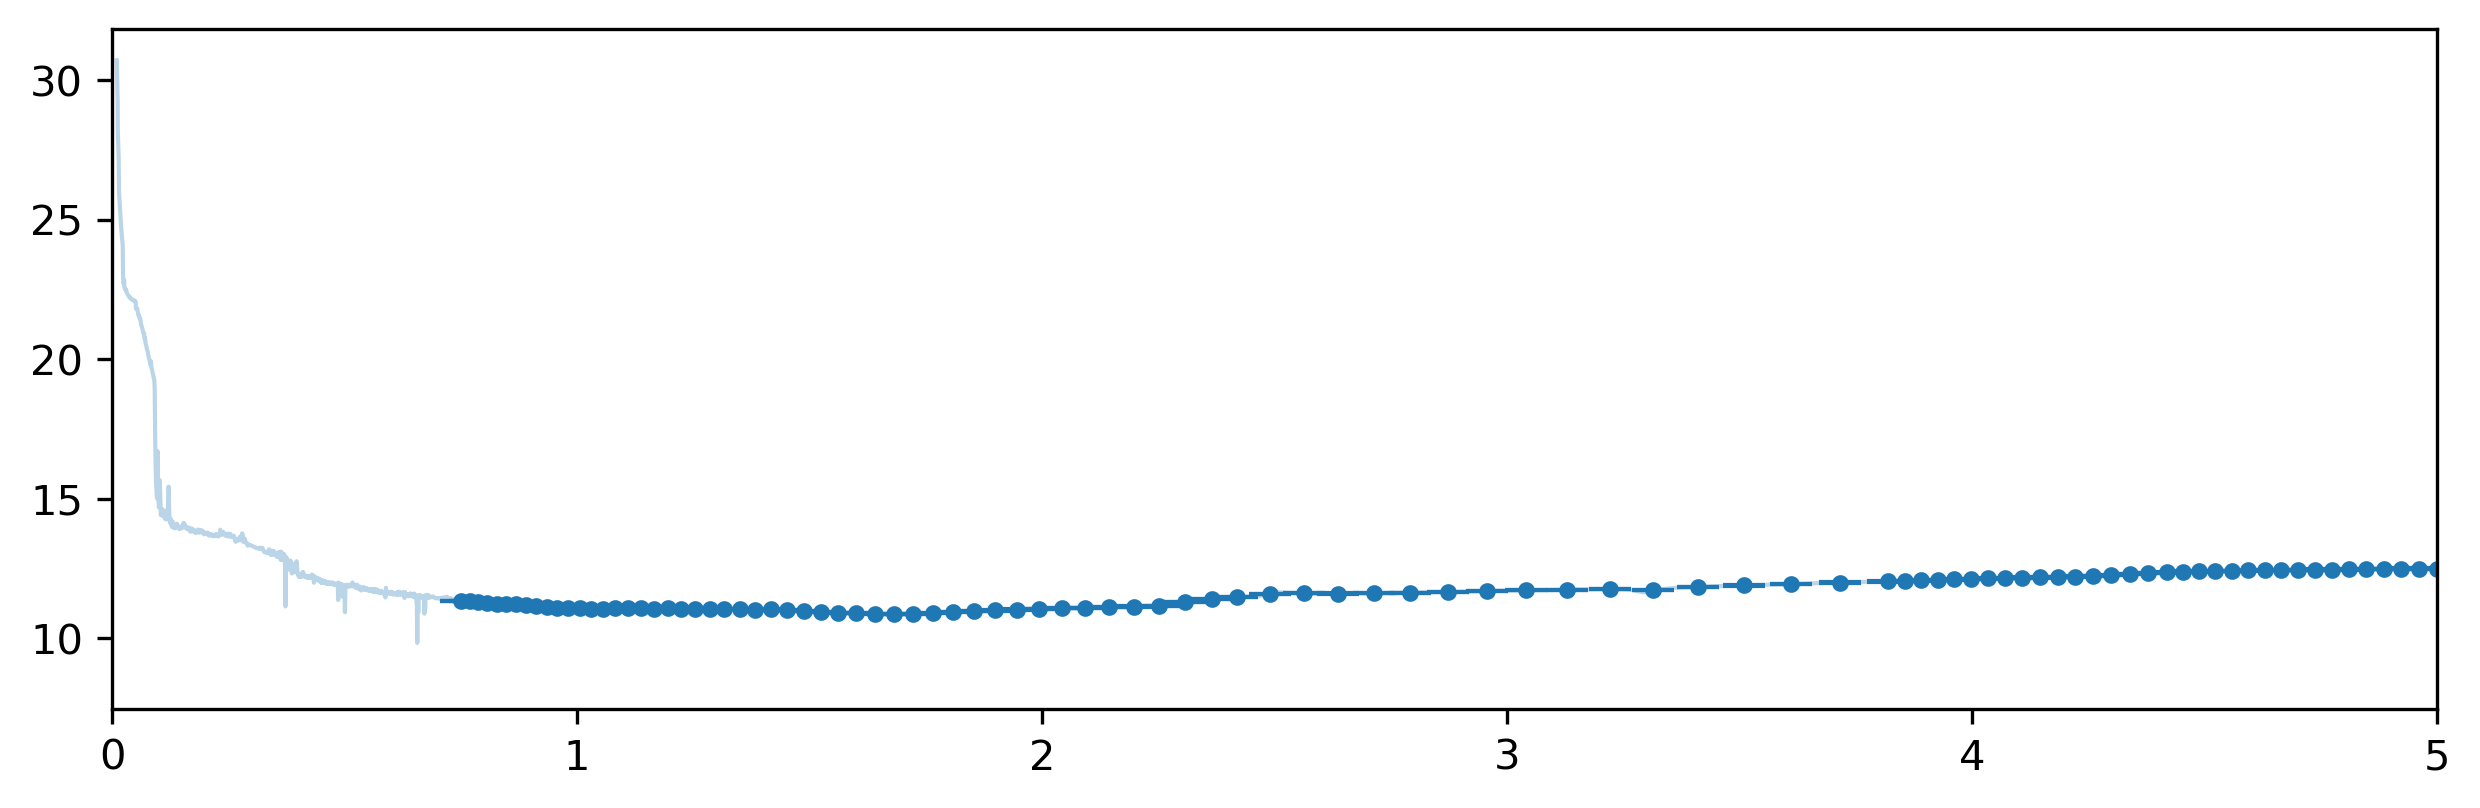

In [274]:
plt.figure(figsize = (10,3), dpi = 300)
plt.scatter(T_sens['wavelength'],T_sens['mag_pts'], marker = '.')
plt.errorbar(T_sens['wavelength'],T_sens['mag_pts'],2.5*np.log10(1+1/T_sens['SNR']), fmt = 'none', capsize = 5)
#plt.plot(wl_um, -2.5*np.log10(f_nu_obs)-48.60, alpha = 0.2)
plt.plot(data['WAVELENGTH']*1e-4, -2.5*np.log10(data['FLUX'] * data['WAVELENGTH'] *data['WAVELENGTH'] *1e-8/ c_cm) - 48.60, alpha = 0.3, linewidth = 1)
plt.xlim(0,5)
#plt.ylim(10,13)